**Prevendo se o resultado de uma eleição para um candidato no Brasil**



**1. Introdução**

O ano de 2018 marcou mais um ano eleitoral para o Brasil, cuja população foi às urnas para eleger os 513 deputados federais e 54 senadores, deputados estaduais e governadores, e finalmente o presidente da república. O andamento do processo eleitoral foi bastante polêmico, com uso intenso das redes sociais e sob constantes acusações do uso de fake news por diferentes candidatos e partidos políticos. Ao final das eleições, foi notório que houve uma grande renovação nos nomes dos candidatos eleitos ao congresso e também nos estados.

Esta eleição de 2018 também foi a primeira deste tipo (parlamentares, governadores, e presidente) após a proibição da doação de empresas, o que poderia sugerir uma diminuição da influência do poder econômico nos resultados. Além disso, o ano de 2018 já marcava um ano em que se cobrava maior participação feminina no congresso e era esperado que uma proporção maior de mulheres fossem eleitas em relação ao número de homens, que tradicionalmente são maioria.

Neste sentido, o objetivo deste trabalho é analisar o perfil de cada candidato das eleições de 2018 e criar um modelo de aprendizagem de máquina que levando em consideração suas características consiga prever se ele seria eleito ou não nas eleições de 2018. O Tribunal Superior Eleitorial (TSE) do Brasil disponibiliza em seu portal um repositório com diversas base de dados com informações sobre as eleições já concluídas. Tais bases incluem informações a respeito dos resultados, do perfil dos eleitores, do perfil dos candidatos, etc. 

O repositório citado acima pode ser encontrado em:

http://www.tse.jus.br/eleicoes/estatisticas/repositorio-de-dados-eleitorais-1/repositorio-de-dados-eleitorais

Todo o projeto descrito a seguir é baseados nas notas de aula da discplina de mestrado de Aprendizagem de Máquina, ministrada pelo professor Dr. Ivanovitch Medeiros Dantas da Silva da Universidade Federal do Rio Grande do Norte (UFRN), que podem ser encontradas no seguinte endereço:

https://github.com/ivanovitchm/EEC1509_Machine_Learning_2019_2

**2. Escolhando e Analisando a Base de Dados**

No repositório do TSE, são disponibilizados diversos arquivos referentes à eleição de 2018. Como o objetivo deste trabalho é analisar se um candidato é eleito ou não baseado em suas características, a melhor base de dados que tais informações são encontradas é a "Candidatos (formato ZIP)", encontrada em:

http://agencia.tse.jus.br/estatistica/sead/odsele/consulta_cand/consulta_cand_2018.zip

Dentro do arquivo compactado, encontram-se os resultados por estado e para todo o país, logo este último será utilizado. O nome do arquivo chama-se "consulta_cand_2018_BRASIL.csv".

Outra base de dados interessante é a dos bens dos candidatos. Com ela, será possível calcular o quão rico um candidato é baseado no valor de seus bens e então usar tal resultado como uma nova coluna durante a feature engineering. Tal base é dispobilizada em:

http://agencia.tse.jus.br/estatistica/sead/odsele/bem_candidato/bem_candidato_2018.zip

Um detalhe importante é que todos os arquivos disponibilizados acima estão formatados em latin1. Então, para facilitar a utilização deles aqui, eles foram convertidos para UTF8 usando o LibreOffice 5.0. Os arquivos com as codificações corrigidas podem ser encontrados em:

https://github.com/DenisMedeiros/EEC1509---Aprendizado-de-Maquina/tree/master/ProjetoFinal

O primeiro passo é carregar o arquivo com os dados dos candidatos para analisá-lo.

In [80]:
# Carregando todas as bibliotecas necessárias.

# Restart run time after installing libraries.
!pip3 install eli5

# Importing all required libraries

import eli5 

import time
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold
from sklearn.feature_selection import chi2
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import SelectFromModel
from joblib import dump, load
from sklearn.neural_network import MLPClassifier

In [81]:
# Carrega as bases de dados. Por padrão, elas estão codificadas em latin1 mas já foram convertidas previamente para utf-8.
candidatos = pd.read_csv("utf8_consulta_cand_2018_BRASIL.csv", sep=";", encoding="utf-8")
bens = pd.read_csv("utf8_bem_candidato_2018_BRASIL.csv", sep=";", encoding="utf-8", decimal=',')

print("Formato da Base de Dados dos Candidatos: {}".format(candidatos.shape))
print("Formato da Base de Dados dos Bens: {}".format(bens.shape))

Formato da Base de Dados dos Candidatos: (29145, 58)
Formato da Base de Dados dos Bens: (93271, 19)


In [82]:
candidatos.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,SG_UF,SG_UE,NM_UE,CD_CARGO,DS_CARGO,SQ_CANDIDATO,NR_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,NM_SOCIAL_CANDIDATO,NR_CPF_CANDIDATO,NM_EMAIL,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,CD_DETALHE_SITUACAO_CAND,DS_DETALHE_SITUACAO_CAND,TP_AGREMIACAO,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,SQ_COLIGACAO,NM_COLIGACAO,DS_COMPOSICAO_COLIGACAO,CD_NACIONALIDADE,DS_NACIONALIDADE,SG_UF_NASCIMENTO,CD_MUNICIPIO_NASCIMENTO,NM_MUNICIPIO_NASCIMENTO,DT_NASCIMENTO,NR_IDADE_DATA_POSSE,NR_TITULO_ELEITORAL_CANDIDATO,CD_GENERO,DS_GENERO,CD_GRAU_INSTRUCAO,DS_GRAU_INSTRUCAO,CD_ESTADO_CIVIL,DS_ESTADO_CIVIL,CD_COR_RACA,DS_COR_RACA,CD_OCUPACAO,DS_OCUPACAO,NR_DESPESA_MAX_CAMPANHA,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,ST_REELEICAO,ST_DECLARAR_BENS,NR_PROTOCOLO_CANDIDATURA,NR_PROCESSO
0,27/11/2019,18:10:02,2018,2,ELEIÇÃO ORDINÁRIA,1,297,Eleições Gerais Estaduais 2018,07/10/2018,ESTADUAL,MA,MA,MARANHÃO,6,DEPUTADO FEDERAL,100000615067,3156,LEIDIANIA PEREIRA DA SILVA VELOSO,LEIDY VELOSO,#NULO#,1137254343,DRJOABSONJUNIOR@HOTMAIL.COM,12,APTO,2,DEFERIDO,COLIGAÇÃO,31,PHS,PARTIDO HUMANISTA DA SOLIDARIEDADE,100000050395,JUNTOS PELO MARANHÃO,PMN / PHS,1,BRASILEIRA NATA,MA,-3,IMPERATRIZ,25/05/1983,35,44509101139,4,FEMININO,6,ENSINO MÉDIO COMPLETO,1,SOLTEIRO(A),1,BRANCA,581,DONA DE CASA,0,5,SUPLENTE,N,N,-1,"6,0063517201861E+018"
1,27/11/2019,18:10:02,2018,2,ELEIÇÃO ORDINÁRIA,1,297,Eleições Gerais Estaduais 2018,07/10/2018,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,250000623664,28282,FABIO SILINGARDI,FABIO SILINGARDI,#NULO#,25700485850,CONTATO@FIDELIX.ADV.BR,12,APTO,2,DEFERIDO,PARTIDO ISOLADO,28,PRTB,PARTIDO RENOVADOR TRABALHISTA BRASILEIRO,250000050631,PARTIDO ISOLADO,PRTB,1,BRASILEIRA NATA,SP,-3,SÃO BERNARDO DO CAMPO,12/10/1977,41,260149590141,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,1,SOLTEIRO(A),1,BRANCA,125,ADMINISTRADOR,0,4,NÃO ELEITO,N,N,-1,"6,04364072018626E+018"
2,27/11/2019,18:10:02,2018,2,ELEIÇÃO ORDINÁRIA,1,297,Eleições Gerais Estaduais 2018,07/10/2018,ESTADUAL,RJ,RJ,RIO DE JANEIRO,7,DEPUTADO ESTADUAL,190000626226,28033,HAMILTON LUIS DIAS SODRÉ,HAMILTON SODRÉ,#NULO#,3407198779,PRTB.RJ28@YAHOO.COM.BR,12,APTO,2,DEFERIDO,PARTIDO ISOLADO,28,PRTB,PARTIDO RENOVADOR TRABALHISTA BRASILEIRO,190000050716,PARTIDO ISOLADO,PRTB,1,BRASILEIRA NATA,RJ,-3,RIO DE JANEIRO,19/01/1973,46,88354290361,2,MASCULINO,8,SUPERIOR COMPLETO,3,CASADO(A),1,BRANCA,297,SERVIDOR PÚBLICO ESTADUAL,0,5,SUPLENTE,N,N,-1,"6,03944942018619E+018"
3,27/11/2019,18:10:02,2018,2,ELEIÇÃO ORDINÁRIA,1,297,Eleições Gerais Estaduais 2018,07/10/2018,ESTADUAL,MA,MA,MARANHÃO,7,DEPUTADO ESTADUAL,100000625316,28200,GUTEMBERG FERNANDES DE ARAÚJO,DR. GUTEMBERG,#NULO#,18022863300,GUTEMBERGARAUJO@ELOINTERNET.COM.BR,12,APTO,2,DEFERIDO,PARTIDO ISOLADO,28,PRTB,PARTIDO RENOVADOR TRABALHISTA BRASILEIRO,100000050678,PARTIDO ISOLADO,PRTB,1,BRASILEIRA NATA,MA,-3,COROATÁ,18/02/1956,62,681281180,2,MASCULINO,8,SUPERIOR COMPLETO,3,CASADO(A),1,BRANCA,111,MÉDICO,0,5,SUPLENTE,N,S,-1,"6,0082577201861E+018"
4,27/11/2019,18:10:02,2018,2,ELEIÇÃO ORDINÁRIA,1,297,Eleições Gerais Estaduais 2018,07/10/2018,ESTADUAL,RJ,RJ,RIO DE JANEIRO,7,DEPUTADO ESTADUAL,190000623227,18456,CRISTIANO DESKIS BARBOSA,CRISTIANO DESKIS,#NULO#,4497130754,VTATSCH.ADV@GMAIL.COM,12,APTO,2,DEFERIDO,PARTIDO ISOLADO,18,REDE,REDE SUSTENTABILIDADE,190000050621,PARTIDO ISOLADO,REDE,1,BRASILEIRA NATA,RJ,-3,CAMPOS DOS GOYTACAZES,15/03/1973,45,84480580302,2,MASCULINO,6,ENSINO MÉDIO COMPLETO,3,CASADO(A),2,PRETA,128,ASTRÔNOMO,0,4,NÃO ELEITO,N,N,-1,"6,03476332018619E+018"


In [83]:
bens.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,SG_UF,SG_UE,NM_UE,SQ_CANDIDATO,NR_ORDEM_CANDIDATO,CD_TIPO_BEM_CANDIDATO,DS_TIPO_BEM_CANDIDATO,DS_BEM_CANDIDATO,VR_BEM_CANDIDATO,DT_ULTIMA_ATUALIZACAO,HH_ULTIMA_ATUALIZACAO
0,27/11/2019,18:09:47,2018,2,Eleição Ordinária,297,Eleições Gerais Estaduais 2018,07/10/2018,MS,MS,MATO GROSSO DO SUL,120000618455,1,11,Apartamento,#NULO#,34698.63,15/10/2018,17:34:13
1,27/11/2019,18:09:47,2018,2,Eleição Ordinária,297,Eleições Gerais Estaduais 2018,07/10/2018,MS,MS,MATO GROSSO DO SUL,120000618455,18,13,Terreno,#NULO#,1387.93,15/10/2018,17:34:13
2,27/11/2019,18:09:47,2018,2,Eleição Ordinária,297,Eleições Gerais Estaduais 2018,07/10/2018,MS,MS,MATO GROSSO DO SUL,120000618455,91,59,Outros créditos e poupança vinculados,#NULO#,311.53,15/10/2018,17:34:13
3,27/11/2019,18:09:47,2018,2,Eleição Ordinária,297,Eleições Gerais Estaduais 2018,07/10/2018,SP,SP,SÃO PAULO,250000618631,12,41,Caderneta de poupança,CADERNETA DE POUPANÇA - BANCO SANTANDER,544.09,21/03/2019,15:33:03
4,27/11/2019,18:09:47,2018,2,Eleição Ordinária,297,Eleições Gerais Estaduais 2018,07/10/2018,GO,GO,GOIÁS,90000620626,1,21,"Veículo automotor terrestre: caminhão, automóv...",#NULO#,36000.00,15/10/2018,11:32:12


Do resultado dos candidatos, nota-se que há 29145 candidatos e são dispobilizadas 58 colunas. É interessante notar que muitas colunas são diretamente relacionadas: uma possui o código numérico (colunas que começão com o prefixo "CD") e a outra a descrição de tal código (começam com o prefixo "DS"). Esse detalhe pode ser encontrado no arquivo leiame.pdf, que explica detalhadamente cada coluna.

Já sobre os bens, existem mais de 90 mil declarados, já que vários candidatos possuem mais de uma casa, carro, terreno, etc.

O passo seguinte é exibir o formato das bases de dados.

In [84]:
candidatos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29145 entries, 0 to 29144
Data columns (total 58 columns):
DT_GERACAO                       29145 non-null object
HH_GERACAO                       29145 non-null object
ANO_ELEICAO                      29145 non-null int64
CD_TIPO_ELEICAO                  29145 non-null int64
NM_TIPO_ELEICAO                  29145 non-null object
NR_TURNO                         29145 non-null int64
CD_ELEICAO                       29145 non-null int64
DS_ELEICAO                       29145 non-null object
DT_ELEICAO                       29145 non-null object
TP_ABRANGENCIA                   29145 non-null object
SG_UF                            29145 non-null object
SG_UE                            29145 non-null object
NM_UE                            29145 non-null object
CD_CARGO                         29145 non-null int64
DS_CARGO                         29145 non-null object
SQ_CANDIDATO                     29145 non-null int64
NR_CANDIDATO     

In [85]:
bens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93271 entries, 0 to 93270
Data columns (total 19 columns):
DT_GERACAO               93271 non-null object
HH_GERACAO               93271 non-null object
ANO_ELEICAO              93271 non-null int64
CD_TIPO_ELEICAO          93271 non-null int64
NM_TIPO_ELEICAO          93271 non-null object
CD_ELEICAO               93271 non-null int64
DS_ELEICAO               93271 non-null object
DT_ELEICAO               93271 non-null object
SG_UF                    93271 non-null object
SG_UE                    93271 non-null object
NM_UE                    93271 non-null object
SQ_CANDIDATO             93271 non-null int64
NR_ORDEM_CANDIDATO       93271 non-null int64
CD_TIPO_BEM_CANDIDATO    93271 non-null int64
DS_TIPO_BEM_CANDIDATO    93271 non-null object
DS_BEM_CANDIDATO         93271 non-null object
VR_BEM_CANDIDATO         93271 non-null float64
DT_ULTIMA_ATUALIZACAO    93271 non-null object
HH_ULTIMA_ATUALIZACAO    93271 non-null object
dty

Como se vê acima na tabela dos candidatos, a coluna alvo será CD_SIT_TOT_TURNO, cujos códigos representam a descrição da coluna DS_SIT_TOT_TURNO, e descreve a situação final do candidato (se foi eleito ou não). Os valores possíveis dessas colunas são mostrados abaixo e ambos são de fato perfeitamente relacionados.

In [86]:
candidatos.CD_SIT_TOT_TURNO.value_counts()

 5    18666
 4     6892
-1     1745
 2     1275
 3      297
 1      210
 6       60
Name: CD_SIT_TOT_TURNO, dtype: int64

In [87]:
candidatos.DS_SIT_TOT_TURNO.value_counts()

SUPLENTE            18666
NÃO ELEITO           6892
#NULO#               1745
ELEITO POR QP        1275
ELEITO POR MÉDIA      297
ELEITO                210
2º TURNO               60
Name: DS_SIT_TOT_TURNO, dtype: int64

Logo, a partir das colunas acima, será criada uma nova coluna binária posteriormente chamada de CANDIDATO_ELEITO, em que possuirá valor 1 se o candidato foi "ELEITO POR QP", "ELEITO POR MÉDIA", ou "ELEITO"; e 0 caso contrário. 

Outro detalhe importante notado acima mas que pode ser melhor confirmado abaixo é que não existem valores nulos nas base de dados.

In [88]:
candidatos.isnull().sum()

DT_GERACAO                       0
HH_GERACAO                       0
ANO_ELEICAO                      0
CD_TIPO_ELEICAO                  0
NM_TIPO_ELEICAO                  0
NR_TURNO                         0
CD_ELEICAO                       0
DS_ELEICAO                       0
DT_ELEICAO                       0
TP_ABRANGENCIA                   0
SG_UF                            0
SG_UE                            0
NM_UE                            0
CD_CARGO                         0
DS_CARGO                         0
SQ_CANDIDATO                     0
NR_CANDIDATO                     0
NM_CANDIDATO                     0
NM_URNA_CANDIDATO                0
NM_SOCIAL_CANDIDATO              0
NR_CPF_CANDIDATO                 0
NM_EMAIL                         0
CD_SITUACAO_CANDIDATURA          0
DS_SITUACAO_CANDIDATURA          0
CD_DETALHE_SITUACAO_CAND         0
DS_DETALHE_SITUACAO_CAND         0
TP_AGREMIACAO                    0
NR_PARTIDO                       0
SG_PARTIDO          

In [89]:
bens.isnull().sum()

DT_GERACAO               0
HH_GERACAO               0
ANO_ELEICAO              0
CD_TIPO_ELEICAO          0
NM_TIPO_ELEICAO          0
CD_ELEICAO               0
DS_ELEICAO               0
DT_ELEICAO               0
SG_UF                    0
SG_UE                    0
NM_UE                    0
SQ_CANDIDATO             0
NR_ORDEM_CANDIDATO       0
CD_TIPO_BEM_CANDIDATO    0
DS_TIPO_BEM_CANDIDATO    0
DS_BEM_CANDIDATO         0
VR_BEM_CANDIDATO         0
DT_ULTIMA_ATUALIZACAO    0
HH_ULTIMA_ATUALIZACAO    0
dtype: int64

**3. Feature Engineering**

A base de dados original dos candidatos possui uma quantidade muito grande de colunas, muitas das quase contém informações irrelevantes para este projeto. Por exemplo, colunas referentes à geração da base de dados em si ou a eleição são irrelevantes pois o foco é analisar características socio-econômicas e pessoais de cada invidíduo. Além disso, muitas colunas vem em pares conforme já explicado anteriormente, logo pode-se escolher manter apenas o código, o que seria equivalente ao tipo de codificação label encoding ou manter a descrição para se decidir depois a codificação (label encoding, one hot encoding, etc).

Nesse sentido, as seguintes colunas serão selecionadas:

4. NR_IDADE_DATA_POSSE - Idade do candidato na data da posse.
5. DS_GENERO - Gênero do candidato.
6. DS_GRAU_INSTRUCAO - Grau de instrução do candidato.
7. DS_ESTADO_CIVIL - Estado civil do candidato.
8. DS_COR_RACA - Raça/etnia do candidato.
9. DS_OCUPACAO - Ocupação do candidato.
10. CD_SIT_TOT_TURNO - Resultado da eleição para o candidato (coluna alvo).
11. SQ_CANDIDATO - Identificador único do candidato utilizado para calcular os bens do candidato na outra base de dados.

Já na base de dados de bens, serão mantidos apenas as seguintes:

1. VR_BEM_CANDIDATO - Valor do bem do candidato.
2. SQ_CANDIDATO - Identificador único do candidato.

In [0]:
# Cria as novas base de dados resumidas.

candidatos2 = candidatos[["NR_IDADE_DATA_POSSE", "DS_GENERO", "DS_GRAU_INSTRUCAO", 
                          "DS_ESTADO_CIVIL", "DS_COR_RACA", "DS_OCUPACAO", "CD_SIT_TOT_TURNO", 
                          "SQ_CANDIDATO"]].copy()

bens2 = bens[["VR_BEM_CANDIDATO", "SQ_CANDIDATO"]].copy()

O passo seguinte é agrupar o valor somado dos bens pelo número de identificação do candidato. 

In [0]:
# Cria uma Series com o valor total para cada identificador.

valor_bens = bens2.groupby(['SQ_CANDIDATO'])[['VR_BEM_CANDIDATO']].agg('sum')


In [92]:
candidatos2.head()

,NR_IDADE_DATA_POSSE,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_COR_RACA,DS_OCUPACAO,CD_SIT_TOT_TURNO,SQ_CANDIDATO
0,35,FEMININO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),BRANCA,DONA DE CASA,5,100000615067
1,41,MASCULINO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),BRANCA,ADMINISTRADOR,4,250000623664
2,46,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,SERVIDOR PÚBLICO ESTADUAL,5,190000626226
3,62,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,MÉDICO,5,100000625316
4,45,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),PRETA,ASTRÔNOMO,4,190000623227


Finalmente, adiciona o valor de bens a cada candidato. Os inexistentes serão considerados 0 (sem bens declarados). 

In [0]:
# Se arquivo com os bens já existe, ignora sua geração (demora mais de 30 segundos para gerar).

try:
  candidatos2 = pd.read_csv("candidatos_bens.csv", sep=";", encoding="utf8")
except:
  # Inicializa todos os candidatos como zero.
  candidatos2["VALOR_BENS"] = 0.0

  # Adiciona o valor dos bens aos que possuem bens.
  for index, row in valor_bens.iterrows():
    candidatos2.loc[candidatos2["SQ_CANDIDATO"] == index, "VALOR_BENS"] = row.VR_BEM_CANDIDATO

  # Já que este é um processo demorado, salva um novo arquivo CSV.
  candidatos2.to_csv("candidatos_bens.csv", sep=';')

# Remove SQ_CANDIDATO
if "SQ_CANDIDATO" in candidatos2.columns:
  candidatos2.drop('SQ_CANDIDATO', axis=1, inplace=True)

O passo seguinte é criar a coluna alvo do tipo binária, conforme descrito anteriormente.

In [94]:
candidatos2.head()

,Unnamed: 0,NR_IDADE_DATA_POSSE,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_COR_RACA,DS_OCUPACAO,CD_SIT_TOT_TURNO,VALOR_BENS
0,0,35,FEMININO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),BRANCA,DONA DE CASA,5,0.00
1,1,41,MASCULINO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),BRANCA,ADMINISTRADOR,4,0.00
2,2,46,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,SERVIDOR PÚBLICO ESTADUAL,5,0.00
3,3,62,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,MÉDICO,5,507722.18
4,4,45,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),PRETA,ASTRÔNOMO,4,0.00


In [0]:
# Define todos os candidatos como não eleitos (cria nova coluna alvo).
candidatos2["SE_ELEGEU"] = 0

# Candidatos com código 1, 2 ou 3 são considerados eleitos.
candidatos2.loc[candidatos2["CD_SIT_TOT_TURNO"].isin([1, 2, 3]), "SE_ELEGEU"] = 1

# Remove a coluna alvo antiga.
if "CD_SIT_TOT_TURNO" in candidatos2.columns:
  candidatos2.drop('CD_SIT_TOT_TURNO', axis=1, inplace=True)


In [96]:
candidatos2.SE_ELEGEU.value_counts()


0    27363
1     1782
Name: SE_ELEGEU, dtype: int64

In [97]:
candidatos2.head()

,Unnamed: 0,NR_IDADE_DATA_POSSE,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_COR_RACA,DS_OCUPACAO,VALOR_BENS,SE_ELEGEU
0,0,35,FEMININO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),BRANCA,DONA DE CASA,0.00,0
1,1,41,MASCULINO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),BRANCA,ADMINISTRADOR,0.00,0
2,2,46,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,SERVIDOR PÚBLICO ESTADUAL,0.00,0
3,3,62,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,MÉDICO,507722.18,0
4,4,45,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),PRETA,ASTRÔNOMO,0.00,0


Neste momento a base de dados já está pronta para ser trabalhada. A seguir, serão selecionadas algumas colunas consideradas relevantes para se observar como elas estão relacionadas com a coluna alvo.

Proporção de homens e mulheres entre os eleitos
MASCULINO    0.838945
FEMININO     0.161055
Name: DS_GENERO, dtype: float64



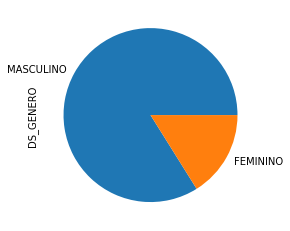

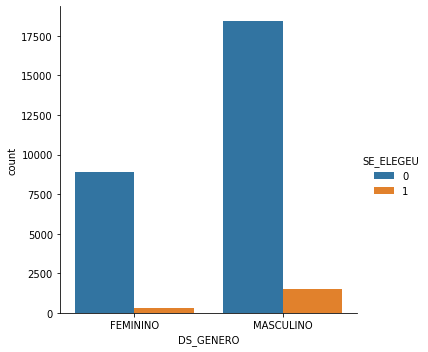

In [98]:
# Análise para o sexo do candidato.

result_genero = candidatos2.loc[candidatos2["SE_ELEGEU"]==1, "DS_GENERO"].value_counts()
print("Proporção de homens e mulheres entre os eleitos")
print(result_genero/result_genero.sum())
print()

result_genero.plot.pie()

sns.catplot(x="DS_GENERO", hue="SE_ELEGEU", data=candidatos2, kind="count")

Como se vê nos gráficos acima, entre os candidatos eleitos a grande maioria (mais de 80%) são homens, o que ainda mantém uma tendência dos homens serem maioria na política.

Proporção de raças/etnias entre os eleitos
BRANCA    0.720539
PARDA     0.234007
PRETA     0.042649
OUTRA     0.002806
Name: DS_COR_RACA, dtype: float64



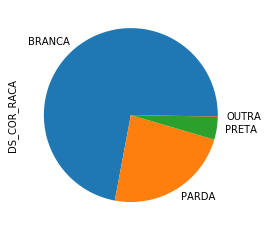

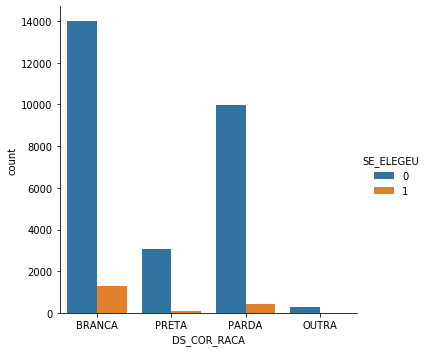

In [99]:
# Análise para a raça/etnia.

candidatos2.loc[~candidatos2["DS_COR_RACA"].isin(
   ['BRANCA', 'PARDA', 'PRETA']), "DS_COR_RACA"] = "OUTRA"

result_raca = candidatos2.loc[candidatos2["SE_ELEGEU"]==1, "DS_COR_RACA"].value_counts()
print("Proporção de raças/etnias entre os eleitos")
print(result_raca/result_raca.sum())
print()

result_raca.plot.pie()

sns.catplot(x="DS_COR_RACA", hue="SE_ELEGEU", data=candidatos2, kind="count")

Do resultado étnico, percebe-se que a maioria dos candidatos eleitos são brancos sendo os pretos e demais a pequena minoria (menos de 5% dos eleitos). Talvez isso reflita um pouco da desigualdade social do Brasil para as populações afro-decendentes.

In [100]:
# Análise para o grau de instrução.

# Reduzindo os nomes dos graus.
candidatos2.DS_GRAU_INSTRUCAO.replace(
    ['SUPERIOR COMPLETO', 'ENSINO MÉDIO COMPLETO', 'SUPERIOR INCOMPLETO'], 
    ['SUP_C', 'ENS_MED_C', 'SUP_I'], inplace=True)

candidatos2.loc[~candidatos2["DS_GRAU_INSTRUCAO"].isin(
   ['SUP_C', 'ENS_MED_C', 'SUP_I']), "DS_GRAU_INSTRUCAO"] = "BAIXO"

result_grau = candidatos2.loc[candidatos2["SE_ELEGEU"]==1, "DS_GRAU_INSTRUCAO"].value_counts()
print("Proporção de grau de instrução entre os eleitos")
print(result_grau/result_grau.sum())
print()


Proporção de grau de instrução entre os eleitos
SUP_C        0.754209
ENS_MED_C    0.130191
SUP_I        0.084736
BAIXO        0.030864
Name: DS_GRAU_INSTRUCAO, dtype: float64



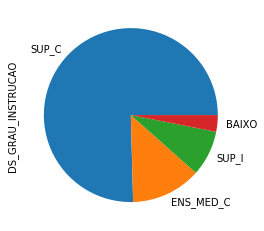

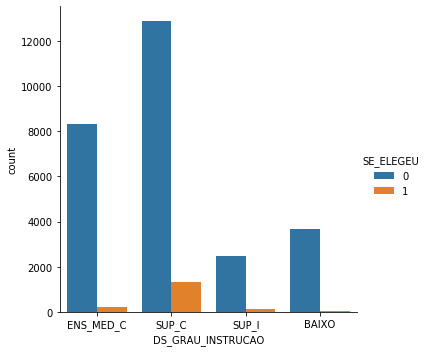

In [101]:
result_grau.plot.pie()

sns.catplot(x="DS_GRAU_INSTRUCAO", hue="SE_ELEGEU", data=candidatos2, kind="count")


Em relação ao grau de instrução, percebe-se que a maioria dos eleitos possui ensino superior completo.

Os passos seguintes consistem em criar-se faixas de valores a idade e o valor dos bens, de modo a se criar duas novas colunas. Além disso, o número de profissões será reduzido pois existem muitas.

count    29145.000000
mean        47.797873
std         12.347219
min         18.000000
25%         40.000000
50%         48.000000
75%         56.000000
max        825.000000
Name: NR_IDADE_DATA_POSSE, dtype: float64


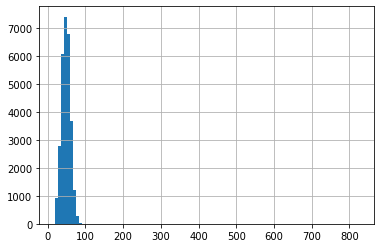

In [102]:
# Analisando as idades.
print(candidatos2.NR_IDADE_DATA_POSSE.describe())

# Exibindo a distribuição de idades.
candidatos2.NR_IDADE_DATA_POSSE.hist(bins=100)

Nota-se que existe uma idade fora dos valores reais, sendo esta 825. Ela será substituída pelo valor mediano.



count    29145.000000
mean        47.771213
std         11.477236
min         18.000000
25%         40.000000
50%         48.000000
75%         56.000000
max         94.000000
Name: NR_IDADE_DATA_POSSE, dtype: float64


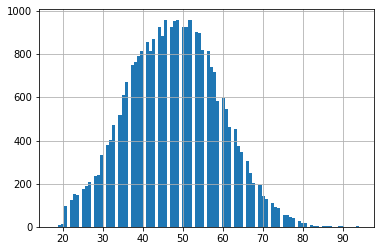

In [103]:
candidatos2.NR_IDADE_DATA_POSSE.replace(
    [825], 
    [candidatos2.NR_IDADE_DATA_POSSE.median()], inplace=True)

print(candidatos2.NR_IDADE_DATA_POSSE.describe())

# Exibindo a distribuição de idades.
candidatos2.NR_IDADE_DATA_POSSE.hist(bins=100)

In [0]:
# Criando faixas de idade.
faixas_idade = [0, 21, 35, 50, 65, 200]
nomes_idade = ["JOVEM", "ADULTO-JOVEM", "ADULTO", "ADULTO-IDOSO", "IDOSO"]
candidatos2["IDADE_CAT"] = pd.cut(candidatos2["NR_IDADE_DATA_POSSE"], faixas_idade, labels=nomes_idade)

In [105]:
# Analisando as faixas de renda.
print(candidatos2.VALOR_BENS.describe())

count    2.914500e+04
mean     8.427223e+05
std      1.500900e+07
min      0.000000e+00
25%      0.000000e+00
50%      3.200000e+04
75%      3.280000e+05
max      1.202007e+09
Name: VALOR_BENS, dtype: float64


In [0]:
# Criando faixas de bens.
faixas_bens = [-1, 10e5, 10e6, 10e7, 10e8, 10e20]
nomes_bens = ["POBRE", "MEDIO", "RICO", "MUITO-RICO", "EXTREMAMENTE-RICO"]
candidatos2["BENS_CAT"] = pd.cut(candidatos2["VALOR_BENS"], faixas_bens, labels=nomes_bens)

Por fim, serão reduzidos as profissões, já que existem 214 conforme mostradas abaixo. Serão mantidas as profissões com mais candidatos eleitos.

In [107]:
# Profissões únicas.
print("Profissões diferentes: ", candidatos2.DS_OCUPACAO.nunique())

profissoes_eleitas = candidatos2[candidatos2["SE_ELEGEU"] == 1].DS_OCUPACAO.value_counts().keys().tolist()
quantidade_eleitos = candidatos2[candidatos2["SE_ELEGEU"] == 1].DS_OCUPACAO.value_counts().tolist()

print(profissoes_eleitas)
print(quantidade_eleitos)

Profissões diferentes:  214
['DEPUTADO', 'EMPRESÁRIO', 'ADVOGADO', 'OUTROS', 'MÉDICO', 'VEREADOR', 'ADMINISTRADOR', 'SERVIDOR PÚBLICO ESTADUAL', 'POLICIAL MILITAR', 'ENGENHEIRO', 'PROFESSOR DE ENSINO SUPERIOR', 'SERVIDOR PÚBLICO FEDERAL', 'JORNALISTA E REDATOR', 'POLICIAL CIVIL', 'SENADOR', 'AGRICULTOR', 'PROFESSOR DE ENSINO MÉDIO', 'MILITAR REFORMADO', 'ECONOMISTA', 'PRODUTOR AGROPECUÁRIO', 'APOSENTADO (EXCETO SERVIDOR PÚBLICO)', 'MEMBRO DAS FORÇAS ARMADAS', 'COMERCIANTE', 'PROFESSOR DE ENSINO FUNDAMENTAL', 'GOVERNADOR', 'PECUARISTA', 'LOCUTOR E COMENTARISTA DE RÁDIO E TELEVISÃO E RADIALISTA', 'SACERDOTE OU MEMBRO DE ORDEM OU SEITA RELIGIOSA', 'SERVIDOR PÚBLICO MUNICIPAL', 'ODONTÓLOGO', 'AGRÔNOMO', 'SERVIDOR PÚBLICO CIVIL APOSENTADO', 'CORRETOR DE IMÓVEIS, SEGUROS, TÍTULOS E VALORES', 'PEDAGOGO', 'ESTUDANTE, BOLSISTA, ESTAGIÁRIO E ASSEMELHADOS', 'SOCIÓLOGO', 'FARMACÊUTICO', 'DONA DE CASA', 'ASSISTENTE SOCIAL', 'BOMBEIRO MILITAR', 'COMUNICÓLOGO', 'CONTADOR', 'VETERINÁRIO', 'BANCÁRIO E 

In [0]:
# Seleciona as 15 profissões mais eleitas.
profissoes_escolhidas = profissoes_eleitas[0:16]

# Substitui as demais profissões por PROFISSAO_SIMPLES.
candidatos2.loc[~candidatos2["DS_OCUPACAO"].isin(
   profissoes_escolhidas), "DS_OCUPACAO"] = "PROFISSAO_SIMPLES"

In [109]:
candidatos2.DS_OCUPACAO.value_counts()

PROFISSAO_SIMPLES               11730
OUTROS                           5688
EMPRESÁRIO                       3021
ADVOGADO                         1830
DEPUTADO                         1126
VEREADOR                          961
SERVIDOR PÚBLICO ESTADUAL         720
ADMINISTRADOR                     695
MÉDICO                            680
POLICIAL MILITAR                  604
SERVIDOR PÚBLICO FEDERAL          457
PROFESSOR DE ENSINO SUPERIOR      430
ENGENHEIRO                        358
JORNALISTA E REDATOR              346
AGRICULTOR                        259
POLICIAL CIVIL                    187
SENADOR                            53
Name: DS_OCUPACAO, dtype: int64

In [110]:
candidatos2.head()

,Unnamed: 0,NR_IDADE_DATA_POSSE,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_COR_RACA,DS_OCUPACAO,VALOR_BENS,SE_ELEGEU,IDADE_CAT,BENS_CAT
0,0,35.0,FEMININO,ENS_MED_C,SOLTEIRO(A),BRANCA,PROFISSAO_SIMPLES,0.00,0,ADULTO-JOVEM,POBRE
1,1,41.0,MASCULINO,ENS_MED_C,SOLTEIRO(A),BRANCA,ADMINISTRADOR,0.00,0,ADULTO,POBRE
2,2,46.0,MASCULINO,SUP_C,CASADO(A),BRANCA,SERVIDOR PÚBLICO ESTADUAL,0.00,0,ADULTO,POBRE
3,3,62.0,MASCULINO,SUP_C,CASADO(A),BRANCA,MÉDICO,507722.18,0,ADULTO-IDOSO,POBRE
4,4,45.0,MASCULINO,ENS_MED_C,CASADO(A),PRETA,PROFISSAO_SIMPLES,0.00,0,ADULTO,POBRE


Neste momento todas as colunas foram ajustadas. O passo seguinte é converter as colunas categóricas para numéricas para se poder fazer a análise de correlação entre as features e a coluna algo.

In [0]:
# Cria uma copia do dataframe.
temp = candidatos2.copy()

# Codifica todas colunas categoricas para numeros.
label_enc = LabelEncoder()
colunas_categoricas = candidatos2.select_dtypes(exclude=['int', 'float']).columns
for coluna in colunas_categoricas:
  temp[coluna] = label_enc.fit_transform(temp[coluna].to_list())

Finalmente, plota-se a tabela de correlação entre as colunas.

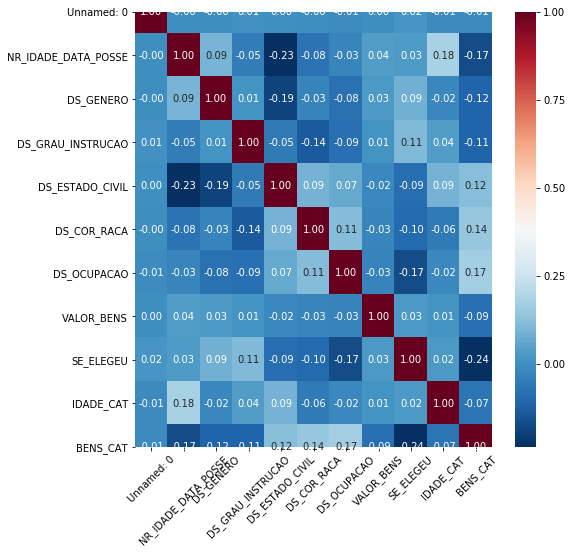

In [112]:
plt.figure(figsize = (8, 8))
sns.heatmap(temp.corr(), cmap=("RdBu_r"), annot=True, fmt='.2f')
plt.xticks(rotation=45) 
plt.yticks(rotation=0) 
plt.show()

Como se vê no mapa de calor mostrado na imagem acima, as features com maior correlação (positiva ou negativa) com a coluna alvo "SE_ELEGEU" são as "BENS_CAT", "DS_COR_RACA" e "DS_GENERO".

Após esta análise preliminar, a etapa seguinte será a de criação do modelo de aprendizagem de máquina para este problema.

**4. Modelo de Aprendizagem de Máquina**

Nesta seção, será criado um modelo de aprendizado de máquina capaz de prever se um candidato será eleito ou não baseado em suas características.

A primeira abordagem será treinar uma random forest para avaliar a feature importance do conjunto de dados. Antes disso, será necessário converter todas as features categóricas para numéricas, mas desta vez utilizando hot enconding. Além disso, será feita uma normalização das colunas de idade e valor de bens, que estão em ordens de grandeza muito diferentes.

Um ponto importante é que a função de scoring utilizada será a de recall em vez de accurary, pois existe um foco em confirmar os candidados marcados como eleitos e que realmente se elegeram.




In [113]:
# Gera a lista de colunas categóricas.
colunas_categoricas = candidatos2.select_dtypes(exclude=['int', 'float']).columns

# Cria-se as novas colunas usando hot encoding.
candidatos_final = pd.get_dummies(candidatos2, drop_first=True, columns=colunas_categoricas)

# Normaliza as colunas dos valores de bens e idade.
mms = MinMaxScaler()

candidatos_final[["NR_IDADE_DATA_POSSE", "VALOR_BENS"]] = mms.fit_transform(candidatos_final[["NR_IDADE_DATA_POSSE", "VALOR_BENS"]])

# Exibe o formato final da base de dados.
candidatos_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29145 entries, 0 to 29144
Data columns (total 39 columns):
Unnamed: 0                                   29145 non-null int64
NR_IDADE_DATA_POSSE                          29145 non-null float64
VALOR_BENS                                   29145 non-null float64
SE_ELEGEU                                    29145 non-null int64
DS_GENERO_MASCULINO                          29145 non-null uint8
DS_GRAU_INSTRUCAO_ENS_MED_C                  29145 non-null uint8
DS_GRAU_INSTRUCAO_SUP_C                      29145 non-null uint8
DS_GRAU_INSTRUCAO_SUP_I                      29145 non-null uint8
DS_ESTADO_CIVIL_DIVORCIADO(A)                29145 non-null uint8
DS_ESTADO_CIVIL_SEPARADO(A) JUDICIALMENTE    29145 non-null uint8
DS_ESTADO_CIVIL_SOLTEIRO(A)                  29145 non-null uint8
DS_ESTADO_CIVIL_VIÚVO(A)                     29145 non-null uint8
DS_COR_RACA_OUTRA                            29145 non-null uint8
DS_COR_RACA_PARDA            

In [114]:
# Prepara o modelo de Random Forest para calcular a feature importance.
seed = 42
num_folds = 10
scoring = {'Accuracy': make_scorer(recall_score)}

kfold = StratifiedKFold(n_splits=num_folds,random_state=seed)
rfc = RandomForestClassifier(oob_score = True, bootstrap = True)

# Cria os conjuntos de teste e treinamento.
X_train, X_test, y_train, y_test = train_test_split(candidatos_final.drop(labels="SE_ELEGEU", axis=1),
                                                    candidatos_final["SE_ELEGEU"],
                                                    test_size=0.20,
                                                    random_state=seed,
                                                    shuffle=True,
                                                    stratify=candidatos_final["SE_ELEGEU"])



search_space = {
    'n_estimators': [100],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 4],
}

grid = GridSearchCV(estimator=rfc, 
                    param_grid=search_space,
                    cv=kfold,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1,
                    refit="Accuracy")

# Verifica se o arquivo do treinamento já existe.
try:
  best_model = load('rf-features.joblib') 
except:
  # Realiza o treinamento da RandomForest.
  best_model = grid.fit(X_train, y_train)
  # Salva o resultado do treinamento.
  dump(best_model, 'rf-features.joblib') 

estimator = best_model.best_estimator_
print(estimator)

# Exibe o resultado.
predict = estimator.predict(X_test)
print(accuracy_score(y_test, predict))
print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))

# # Utilizando a biblioteca ELI5, exibe a feature importance da RandomForest.
eli5.show_weights(estimator, show_feature_values=True, feature_names=X_train.columns.to_list())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)
0.9454451878538342
[[5415   58]
 [ 260   96]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5473
           1       0.62      0.27      0.38       356

    accuracy                           0.95      5829
   macro avg       0.79      0.63      0.67      5829
weighted avg       0.93      0.95      0.94      5829



Weight,Feature
0.3450 ± 0.1834,DS_OCUPACAO_DEPUTADO
0.2149 ± 0.1521,VALOR_BENS
0.1096 ± 0.0298,Unnamed: 0
0.0885 ± 0.0268,NR_IDADE_DATA_POSSE
0.0526 ± 0.1058,BENS_CAT_MEDIO
0.0222 ± 0.0305,DS_OCUPACAO_PROFISSAO_SIMPLES
0.0163 ± 0.0245,DS_GRAU_INSTRUCAO_SUP_C
0.0128 ± 0.0084,DS_COR_RACA_PARDA
0.0107 ± 0.0078,DS_GENERO_MASCULINO
0.0107 ± 0.0140,DS_OCUPACAO_EMPRESÁRIO


O resultado da Ranfom Forest acima já é interessante, com acurácia de 94%. Contudo, o resultado mais interessante e buscado é em relação a feature importance e nesse sentido nota-se que as colunas "DS_OCUPACAO_DEPUTADO" (se o candidato ja era um deputado anteriormente), "VALOR_BENS" (o quão rico ele é), e "NR_IDADE_DATA_POSSE" (idade do candidato) são as mais relevantes.

Com esta análise feita, o passo seguinte será a escolha do melhor modelo de aprendizagem de máquina para este problema.

In [0]:
pipe = Pipeline(
    steps=[
           ('fs', SelectKBest()),
           ('clf', LogisticRegression())
    ]
)

search_space = [
  {"clf":[RandomForestClassifier()],
    "clf__n_estimators": [50, 100],
    "clf__max_leaf_nodes": [64],
    "clf__min_samples_split": [2, 4],
    "clf__random_state": [seed],
    "fs__k": [3, 6, 9, 'all'],
    },
  {"clf":[LogisticRegression()],
    "clf__solver": ["liblinear"],
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.1, 1.0, 10.0],
    "fs__k": [3, 6, 9, 'all'],
    },
    {"clf":[MLPClassifier()],
      "clf__hidden_layer_sizes": [(2,),(4,)],
      "clf__activation": ["logistic", "tanh"],
      "clf__solver": ["sgd"],
      "clf__max_iter": [500],
      "clf__early_stopping":[True],
      "clf__n_iter_no_change":[20],
      "clf__validation_fraction":[0.20], 
       "fs__k": [3, 6, 9, 'all'],
      }
         
    
]

grid = GridSearchCV(estimator=pipe, 
                    param_grid=search_space,
                    cv=kfold,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1,
                    refit="Accuracy")

# Verifica se o arquivo com o treinamento já existe.
try:
  melhor_modelo = load('melhor-modelo.joblib') 
except:
  # Realiza o treinamento da RandomForest.
  tmp = time.time()
  melhor_modelo = grid.fit(X_train, y_train)
  print("Tempo de treinamento: %s seconds" % (str(time.time() - tmp))) 
  # Salva o resultado do treinamento.
  dump(melhor_modelo, 'melhor-modelo.joblib') 




In [116]:
print("Melhor modelo: %f usando %s" % (melhor_modelo.best_score_, melhor_modelo.best_params_))

resultado = pd.DataFrame(melhor_modelo.cv_results_)
resultado.head()

Melhor modelo: 0.380807 usando {'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=64,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False), 'clf__max_leaf_nodes': 64, 'clf__min_samples_split': 2, 'clf__n_estimators': 50, 'clf__random_state': 42, 'fs__k': 3}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__max_leaf_nodes,param_clf__min_samples_split,param_clf__n_estimators,param_clf__random_state,param_fs__k,param_clf__C,param_clf__penalty,param_clf__solver,param_clf__activation,param_clf__early_stopping,param_clf__hidden_layer_sizes,param_clf__max_iter,param_clf__n_iter_no_change,param_clf__validation_fraction,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,split5_test_Accuracy,split6_test_Accuracy,split7_test_Accuracy,split8_test_Accuracy,split9_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,split5_train_Accuracy,split6_train_Accuracy,split7_train_Accuracy,split8_train_Accuracy,split9_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,0.314603,0.004834,0.020146,0.000549,"(DecisionTreeClassifier(class_weight=None, cri...",64,2,50,42,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'clf': (DecisionTreeClassifier(class_weight=N...,0.321678,0.377622,0.377622,0.391608,0.426573,0.356643,0.330986,0.457746,0.366197,0.401408,0.380807,0.039179,1,0.387373,0.381138,0.381138,0.379579,0.375682,0.383476,0.386293,0.372274,0.382399,0.378505,0.380786,0.004347
1,0.413394,0.003882,0.023837,0.000726,"(DecisionTreeClassifier(class_weight=None, cri...",64,2,50,42,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'clf': (DecisionTreeClassifier(class_weight=N...,0.314685,0.356643,0.370629,0.370629,0.405594,0.349650,0.309859,0.436620,0.330986,0.387324,0.363262,0.037870,5,0.370226,0.365549,0.363991,0.363211,0.360094,0.366329,0.370717,0.356698,0.366044,0.362150,0.364501,0.004074
2,0.491676,0.005321,0.026318,0.004292,"(DecisionTreeClassifier(class_weight=None, cri...",64,2,50,42,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'clf': (DecisionTreeClassifier(class_weight=N...,0.314685,0.356643,0.321678,0.342657,0.363636,0.349650,0.316901,0.415493,0.288732,0.338028,0.340811,0.032816,11,0.368667,0.363211,0.322681,0.340608,0.343726,0.363211,0.371495,0.332555,0.346573,0.341121,0.349385,0.015571
3,0.795371,0.016207,0.026328,0.006267,"(DecisionTreeClassifier(class_weight=None, cri...",64,2,50,42,all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'clf': (DecisionTreeClassifier(class_weight=N...,0.181818,0.230769,0.251748,0.188811,0.202797,0.181818,0.211268,0.260563,0.197183,0.260563,0.216731,0.030148,30,0.254092,0.227592,0.260327,0.240062,0.235386,0.257210,0.268692,0.254673,0.246106,0.269470,0.251361,0.013179
4,0.593970,0.012492,0.035711,0.003133,"(DecisionTreeClassifier(class_weight=None, cri...",64,2,100,42,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'clf': (DecisionTreeClassifier(class_weight=N...,0.321678,0.377622,0.377622,0.391608,0.426573,0.356643,0.330986,0.457746,0.366197,0.401408,0.380807,0.039179,1,0.387373,0.381138,0.381138,0.379579,0.375682,0.383476,0.386293,0.372274,0.382399,0.378505,0.380786,0.004347


Após a busca em grade realizada acima, o melhor modelo gerado foi utilizando o RandomForestClassifier, apresentando uma acurácia de aproximadamente 95% no conjunto de treinamento. A seguir, tal modelo será validado com o conjunto de teste.

In [117]:
predicoes = melhor_modelo.best_estimator_.predict(X_test)
print(accuracy_score(y_test, predicoes))
print(confusion_matrix(y_test, predicoes))
print(classification_report(y_test, predicoes))

0.9456167438668726
[[5385   88]
 [ 229  127]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5473
           1       0.59      0.36      0.44       356

    accuracy                           0.95      5829
   macro avg       0.77      0.67      0.71      5829
weighted avg       0.94      0.95      0.94      5829



Como se vê cima, o resultado com o conjunto de teste foi de 94% de acerto, o que é muito bom.


**5. Considerações Finais**

Este trabalho propôs um modelo de aprendizagem de máquina capaz de prever se um determinado candidato, baseado em suas características pessoais e socio-econômicas seria eleito na última eleção no Brasil, realizada em 2018. Os resultados mostraram uma taxa de acerto bem alta, até pelo formato dos dados (a maioria dos candidatos não se elegeram) e também pela previsibilidade real com base na história brasileira.

Sabe-se que tradicionalmente a política no Brasil é controlada majoritariamente por homens, brancos, com formação elavada e principalmente com alto poder econômico. Por fim, sabe-que também que muitos dos políticos perpetuam-se no poder no Brasil, com vários mandados seguidos. Assim, é de se esperar que candidatos cuja ocupação fosse Deputado ou Senador, por exemplo, tivesse grande influência na sua probabiblidade de ser eleito.

